In [133]:
%matplotlib inline

In [134]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb

# Data Pre-processing

In [135]:
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
pam50_proteins = "PAM50_proteins.csv"

In [136]:
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

data.shape # 12553 genes × 85 samples
clinical.shape # 105 sampels x 29 clinical features
pam50 # the 50 genes associated with breast cancer 

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160
5,ACTR3B,NP_065178,Homo sapiens,ARP3 actin-related protein 3 homolog B (yeast)
6,ACTR3B,NP_001035225,Homo sapiens,ARP3 actin-related protein 3 homolog B (yeast)
7,MLPH,NP_001035932,Homo sapiens,melanophilin
8,MLPH,NP_077006,Homo sapiens,melanophilin
9,ERBB2,NP_001005862,Homo sapiens,v-erb-b2 erythroblastic leukemia viral oncogen...


In [137]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()

## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)
 
## Change name to make it look nicer in the code!
processed = merged
 
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]
 
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

## Impute missing values (maybe another method would work better?)
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(processed_numerical_p50)
processed_numerical_p50_imputed = imputer.transform(processed_numerical_p50)

processed_numerical_p50_imputed = pd.DataFrame(processed_numerical_p50_imputed, \
                                               columns = processed_numerical_p50.columns, \
                                               index = processed_numerical_p50.index)

In [138]:
processed_numerical_p50_imputed

RefSeq_accession_number,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,0.896468,-1.792547,0.896468,0.896468,2.516489,2.556897,0.896468
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,0.870903,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-1.410193,0.702364,-1.402538,-0.528047,-0.528047,1.934688,-0.528047,0.798041,2.003576,-0.528047
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,0.018893,-1.574649,-4.515280,-1.648865,-1.648865,2.049328,-1.648865,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199
TCGA-A2-A0EY,-1.015330,-0.840446,-3.059805,-3.638587,-2.547645,5.800973,-3.571964,-6.465874,-6.361777,-6.557480,...,-0.303303,-1.327622,-0.615596,0.204692,-1.169394,-1.169394,-0.490679,-1.169394,-1.169394,-1.169394
TCGA-A2-A0SW,0.293752,0.039676,-5.945578,-3.610654,-1.899662,-4.308558,-3.372659,-2.099063,-1.976850,-1.565183,...,-0.371991,0.419182,-0.774010,-0.371991,-0.510286,-0.317317,-0.371991,0.313049,-0.371991,-0.371991
TCGA-A2-A0SX,1.457488,1.385987,5.625404,3.271828,2.166540,-4.891209,-1.774955,-4.414536,-4.414536,-3.776985,...,-0.551989,-2.063939,0.313471,-0.551989,-0.551989,-1.337011,-0.551989,0.393910,-0.551989,-0.551989
TCGA-A2-A0T3,1.059592,-0.451477,-0.355684,0.305602,0.123285,-3.937134,-3.102801,2.165855,1.597273,1.897015,...,1.516930,0.592984,0.738219,-0.510190,-1.480488,-0.847013,-0.060577,1.921736,-0.060577,-0.060577
TCGA-A2-A0T6,-2.885329,-3.435150,-2.781589,-3.189632,-2.297470,-4.804515,-2.553362,-0.720625,-0.772495,-0.616886,...,0.939211,-2.141861,-3.549264,-1.441617,-1.460636,-0.813991,-1.441617,-1.441617,-1.187454,-7.000341


In [139]:
import numpy as np
processed_numerical_p50_imputed = np.array(processed_numerical_p50_imputed)

# K-Means

In [140]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6,7,8,9,10,20,79]
 
def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4, max_iter = 10)
        clusterer.fit(data)
        silhouette = metrics.silhouette_score(data, clusterer.labels_)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], clusterer.labels_)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_k_means(n_clusters,processed_numerical_p50_imputed)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.2077
Homogeneity score: 0.2073
Adjusted Rand Index 0.2213

------------ k= 3 --------
Silhouette Coefficient: 0.176
Homogeneity score: 0.412
Adjusted Rand Index 0.3784

------------ k= 4 --------
Silhouette Coefficient: 0.1372
Homogeneity score: 0.4362
Adjusted Rand Index 0.3413

------------ k= 5 --------
Silhouette Coefficient: 0.1401
Homogeneity score: 0.535
Adjusted Rand Index 0.3961

------------ k= 6 --------
Silhouette Coefficient: 0.1242
Homogeneity score: 0.4642
Adjusted Rand Index 0.3015

------------ k= 7 --------
Silhouette Coefficient: 0.1035
Homogeneity score: 0.4858
Adjusted Rand Index 0.2328

------------ k= 8 --------
Silhouette Coefficient: 0.1026
Homogeneity score: 0.5626
Adjusted Rand Index 0.2469

------------ k= 9 --------
Silhouette Coefficient: 0.098
Homogeneity score: 0.5903
Adjusted Rand Index 0.261

------------ k= 10 --------
Silhouette Coefficient: 0.1021
Homogeneity score: 0.5357
Adjusted Rand Index 0.18

/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


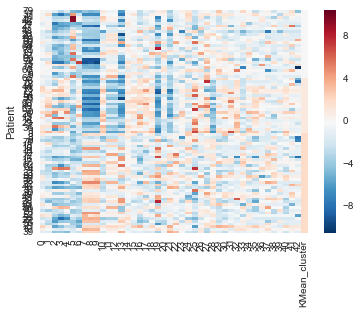

In [141]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
kmean_final = KMeans(n_clusters=3, max_iter=10)
kmean_final = kmean_final.fit(processed_numerical_p50_imputed)
kmean_plot = pd.DataFrame(processed_numerical_p50_imputed)
kmean_plot['KMean_cluster'] = kmean_final.labels_
kmean_plot.sort('KMean_cluster',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
kmean_plot.index.name = 'Patient'
sb.heatmap(kmean_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

In [142]:
kmean_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(kmean_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9,k = 10,k = 20,k = 79
Silhouette Coeff.,0.207735,0.176046,0.137190,0.140148,0.124158,0.103533,0.102624,0.097983,0.102129,0.069141,0.007797
Homogeneity Score,0.207323,0.412024,0.436161,0.535045,0.464171,0.485818,0.562625,0.590329,0.535684,0.698219,1.000000
Adjusted Rand Index,0.221339,0.378389,0.341298,0.396141,0.301492,0.232847,0.246881,0.261040,0.186121,0.163581,0.001860


# Spectral Clustering

In [143]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6,7,8,10,20,79]
 
def compare_spectral(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = SpectralClustering(n_clusters=k, n_jobs=4)
        clusterer.fit(data)
        silhouette = metrics.silhouette_score(data, clusterer.labels_)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], clusterer.labels_)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_spectral(n_clusters,processed_numerical_p50_imputed)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: -0.0033
Homogeneity score: 0.0219
Adjusted Rand Index -0.0056

------------ k= 3 --------
Silhouette Coefficient: -0.0918
Homogeneity score: 0.0562
Adjusted Rand Index 0.0092

------------ k= 4 --------
Silhouette Coefficient: -0.1669
Homogeneity score: 0.0787
Adjusted Rand Index 0.0054

------------ k= 5 --------
Silhouette Coefficient: -0.1743
Homogeneity score: 0.1026
Adjusted Rand Index 0.0041

------------ k= 6 --------
Silhouette Coefficient: -0.1638
Homogeneity score: 0.1241
Adjusted Rand Index -0.0022

------------ k= 7 --------
Silhouette Coefficient: -0.1967
Homogeneity score: 0.1489
Adjusted Rand Index -0.0017

------------ k= 8 --------
Silhouette Coefficient: -0.2098
Homogeneity score: 0.166
Adjusted Rand Index 0.0056

------------ k= 10 --------
Silhouette Coefficient: -0.2105
Homogeneity score: 0.1828
Adjusted Rand Index 0.0116

------------ k= 20 --------
Silhouette Coefficient: -0.2209
Homogeneity score: 0.2704
Adjuste

/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


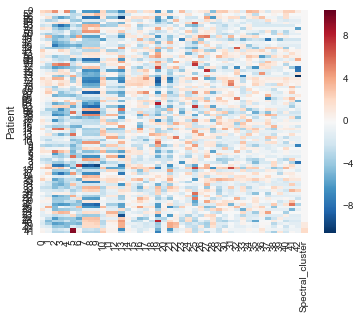

In [144]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
spectral_final = SpectralClustering(n_clusters=3)
spectral_final = spectral_final.fit(processed_numerical_p50_imputed)
spectral_plot = pd.DataFrame(processed_numerical_p50_imputed)
spectral_plot['Spectral_cluster'] = spectral_final.labels_
spectral_plot.sort('Spectral_cluster',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
spectral_plot.index.name = 'Patient'
sb.heatmap(spectral_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

In [145]:
spectral_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(spectral_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 10,k = 20,k = 79
Silhouette Coeff.,-0.003294,-0.091816,-0.166944,-0.174298,-0.163772,-0.196670,-0.209807,-0.210521,-0.220887,-0.283970
Homogeneity Score,0.021929,0.056156,0.078731,0.102563,0.124129,0.148865,0.165989,0.182776,0.270432,0.281783
Adjusted Rand Index,-0.005618,0.009219,0.005373,0.004149,-0.002197,-0.001737,0.005630,0.011567,0.033057,0.011950


# Gaussian Mixture Models

In [146]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6,7,8,10,20,79]
 
def compare_GMM(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = GaussianMixture(n_components=k)
        clusterer.fit(data)
        labels = clusterer.predict(data)
        silhouette = metrics.silhouette_score(data, labels)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], labels)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], labels)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_GMM(n_clusters,processed_numerical_p50_imputed)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.2116
Homogeneity score: 0.2253
Adjusted Rand Index 0.268

------------ k= 3 --------
Silhouette Coefficient: 0.118
Homogeneity score: 0.2644
Adjusted Rand Index 0.2115

------------ k= 4 --------
Silhouette Coefficient: 0.1332
Homogeneity score: 0.3875
Adjusted Rand Index 0.3036

------------ k= 5 --------
Silhouette Coefficient: 0.1245
Homogeneity score: 0.3944
Adjusted Rand Index 0.289

------------ k= 6 --------
Silhouette Coefficient: 0.1125
Homogeneity score: 0.4721
Adjusted Rand Index 0.3507

------------ k= 7 --------
Silhouette Coefficient: 0.0964
Homogeneity score: 0.4902
Adjusted Rand Index 0.2463

------------ k= 8 --------
Silhouette Coefficient: 0.1043
Homogeneity score: 0.5011
Adjusted Rand Index 0.2354

------------ k= 10 --------
Silhouette Coefficient: 0.0607
Homogeneity score: 0.5389
Adjusted Rand Index 0.1981

------------ k= 20 --------
Silhouette Coefficient: 0.0625
Homogeneity score: 0.7049
Adjusted Rand Index 0

/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


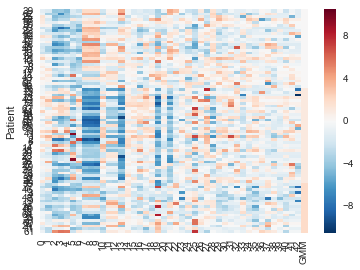

In [147]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
gmm_final = GaussianMixture(n_components=3)
gmm_final = gmm_final.fit(processed_numerical_p50_imputed)
gmm_plot = pd.DataFrame(processed_numerical_p50_imputed)
gmm_plot['GMM'] = gmm_final.predict(processed_numerical_p50_imputed)
gmm_plot.sort('GMM',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
gmm_plot.index.name = 'Patient'
sb.heatmap(gmm_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

In [148]:
gmm_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(gmm_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 10,k = 20,k = 79
Silhouette Coeff.,0.211644,0.117966,0.133209,0.124493,0.112457,0.096442,0.104302,0.060690,0.062499,0.007797
Homogeneity Score,0.225346,0.264404,0.387481,0.394389,0.472057,0.490249,0.501146,0.538875,0.704944,1.000000
Adjusted Rand Index,0.268008,0.211486,0.303562,0.289045,0.350650,0.246270,0.235407,0.198060,0.140365,0.001860
